## Исследование бизнес-показателей приложения:

Заказчик - компания-разработчик прилоложения, поставила задачу - разобраться в причинах убытков последних месяцев. На маркетинг были потрачены большие суммы, но это не помогает. В наличии имеется лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 1 мая по 27 октября 2019 года. Также есть выгрузка их покупок за этот период и статистика рекламных расходов за этот период. Предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы негативно влияют на привлечение новых пользователей.

#### Описание данных
Таблица *visits_log_short* (лог сервера с информацией о посещениях сайта):

- User Id — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Session start — дата и время начала сессии
- Session End — дата и время окончания сессии
- Channel — идентификатор рекламного источника, из которого пришел пользователь
- Region - страна пользователя

Таблица *orders_log_short* (информация о заказах):

- User Id — уникальный id пользователя, который сделал заказ
- Event Dt — дата и время покупки
- Revenue — выручка

Таблица *costs_short* (информация о затратах на маркетинг):

- Channel — идентификатор рекламного источника
- Dt — дата
- Costs — затраты на этот рекламный источник в этот день

### Загрузка и подготовка данных к анализу
Загрузим данные о визитах, заказах и расходах в переменные. Оптимизируем данные для анализа.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs.columns = map(str.lower, costs.columns)
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

### Функции для расчета и анализа LTV, ROI, удержания и конверсии

Для создания пользовательских профилей с датой первого посещения. В ней сгруппируем значения датафрейма по пользовательскому ID и применим функцию first():

In [2]:
# добавляем параметр costs — траты на рекламу
def get_profiles(visits, orders, costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    # for event in event_names:
    #     if event in events['event_name'].unique():
    #         # проверяем, встречается ли каждый пользователь
    #         # среди тех, кто совершил событие event
    #         profiles[event] = profiles['user_id'].isin(
    #             events.query('event_name == @event')['user_id'].unique()
    #         )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [3]:
#вызываем функцию get_profiles, чтобы составить профили пользователей по данным сессий из датафрейма visits:
profiles = get_profiles(visits, orders, costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


#### Функция get_retention

In [4]:
def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция get_conversion

In [5]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция get_ltv

In [6]:
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функции для построения графиков

Напишем функцию filter_data() для сглаживания фрейма с недельным окном.

In [7]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [8]:
def plot_retention(retention, retention_history, horizon, window=5):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [10]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.



In [11]:
profiles = get_profiles(visits, orders, costs)
print('Минимальная дата привлечения пользователей', profiles['first_ts'].min())
print('Максимальная дата привлечения пользователей', profiles['first_ts'].max())

Минимальная дата привлечения пользователей 2019-05-01 00:00:41
Максимальная дата привлечения пользователей 2019-10-27 23:59:04


Минимальная и максимальная дата привлечения пользователей соответствует изучаемому периоду времени.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?


In [12]:
profiles.groupby('region').agg(
    {'user_id': 'count', 'payer':['sum','mean']}).sort_values(
    by=('payer', 'sum'), ascending=False).style.format('{:.2f}'
    )

Имеется 4 страны, из которых приходят пользователи - США, Великобритания, Франция, Германия. Больше всего пользователей из США - и там же больше всего платящих - как по количеству, так и по доле.

- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?


In [13]:
profiles.groupby('device').agg(
    {'user_id': 'count', 'payer':['sum','mean']}).sort_values(
    by=('payer', 'sum'), ascending=False).style.format('{:.2f}'
    )

Пользователи с 4 платформ - IPhone, Android, Mac и PC. У пользователей Mac самая большая доля платящих пользователей. Больше всего платящих пользователей по количеству с IPhone.

- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [14]:
profiles.groupby('channel').agg({'user_id': 'count', 'payer':['sum','mean']}).sort_values(by=('payer', 'sum'), ascending=False)

user_id payer          
                     count   sum      mean
channel                                   
FaceBoom             29144  3557  0.122049
TipTop               19561  1878  0.096007
organic              56439  1160  0.020553
WahooNetBanner        8553   453  0.052964
AdNonSense            3880   440  0.113402
RocketSuperAds        4448   352  0.079137
LeapBob               8553   262  0.030633
OppleCreativeMedia    8605   233  0.027077
lambdaMediaAds        2149   225  0.104700
YRabbit               4312   165  0.038265
MediaTornado          4364   156  0.035747

Самая большая доля у органических переходов, также популярные каналы: FaceBoom, TipTop, WahooNetBanner. Больше всего платящих пользователей с платформ FaceBoom, TipTop и органические.

#### Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [15]:
print('Всего потрачено на рекламу ', "%.2f" % costs['costs'].sum())
print()
#profiles.groupby('channel').agg({'acquisition_cost': 'sum'})
print('Потрачено на привлечение с каждого источника:')
costs.groupby('channel').sum().sort_values(by='costs', ascending=False)


Всего потрачено на рекламу  105497.30

Потрачено на привлечение с каждого источника:


,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Теперь посмотрим затраты на привлечение пользователей по времени:

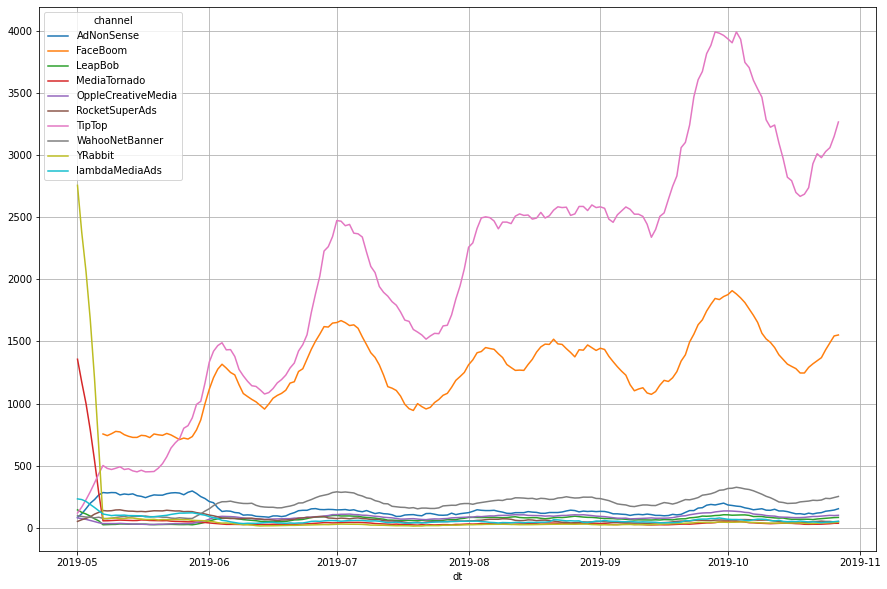

In [16]:
costs['rolling_week'] = costs['costs'].rolling(7).sum() 
costs.pivot_table(
    index='dt',  # даты первых посещений
    columns='channel',  # источники переходов
    values='rolling_week').plot(figsize=(15, 10), grid=True)

plt.show()

In [17]:
profiles.groupby('channel')['acquisition_cost'].mean()

channel
AdNonSense            1.008054
FaceBoom              1.113286
LeapBob               0.210172
MediaTornado          0.218717
OppleCreativeMedia    0.250000
RocketSuperAds        0.412095
TipTop                2.799003
WahooNetBanner        0.602245
YRabbit               0.218975
lambdaMediaAds        0.724802
organic               0.000000
Name: acquisition_cost, dtype: float64

#### Оценка окупаемости рекламы для привлечения пользователей

Проанализируем общую окупаемость рекламы
Смотрим данные 1-го ноября 2019 года, горизонт анализа - две недели. Так как мы изучаем проблемы маркетинга и каналов привлечения, органические переходы ниже в анализе учитывать не будем.

In [18]:
profiles_0 = profiles.query('channel != "organic"') #новая таблица без "органических" пользователей

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,,
All users,88644.000,1.118,0.309,0.390,0.451,0.502,0.547,0.585,0.621,0.653,0.684,0.713,0.739,0.762,0.786,0.807


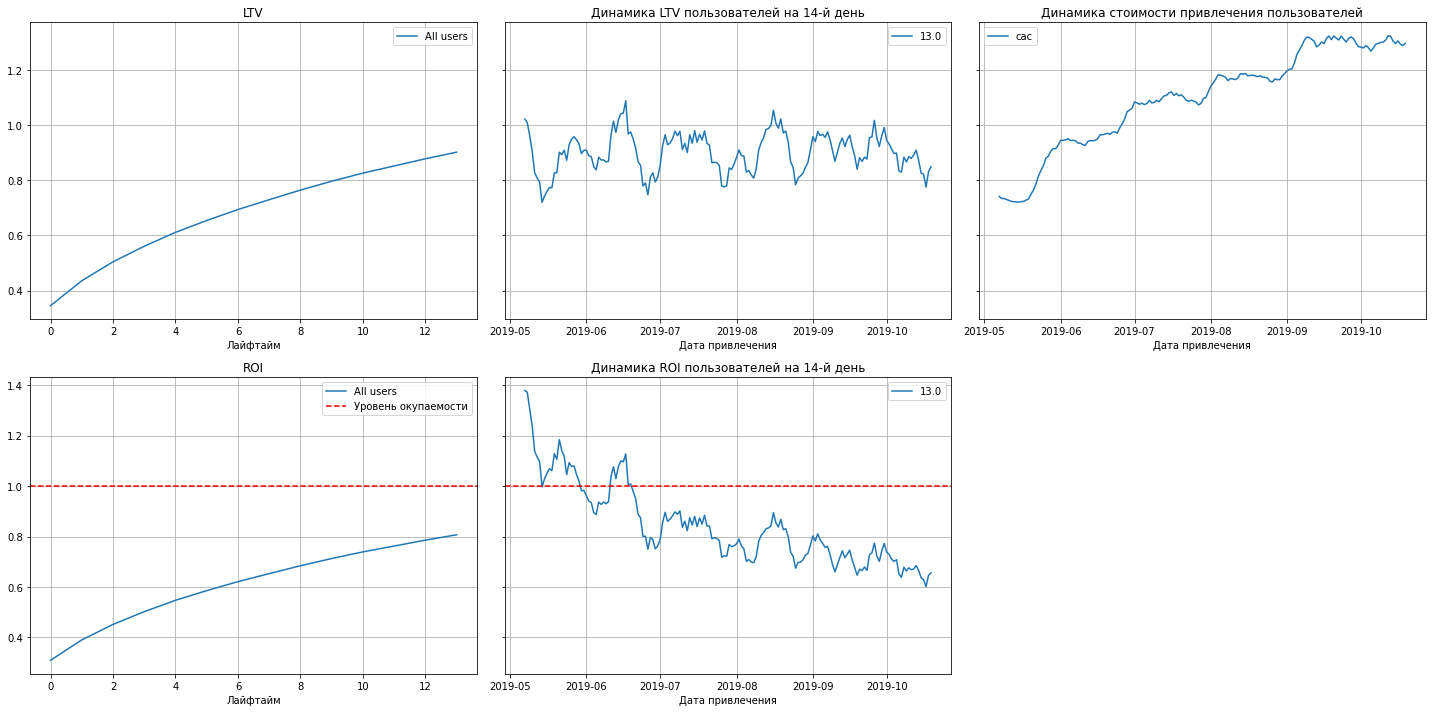

In [19]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_0, orders, datetime(2019, 11, 1).date(), 14, dimensions=[], ignore_horizon=False)
display(roi.style.format('{:.3f}'))

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14)

Средняя стоимость привлечения одного клиента - 1.118. Если смотреть общую динамику, стоимость привлечения пользователей заметно растёт в течение года. Средняя окупаемость в двухнедельный срок только на 80 процентов, ниже целевых показателей.

#### Анализ окупаемости по устройствам

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
device,,,,,,,,,,,,,,,,
Android,20683.00,1.02,0.33,0.42,0.49,0.54,0.60,0.65,0.69,0.72,0.76,0.79,0.82,0.84,0.87,0.89
Mac,17747.00,1.28,0.30,0.38,0.43,0.47,0.51,0.54,0.57,0.59,0.62,0.65,0.67,0.69,0.71,0.73
PC,18128.00,0.79,0.35,0.46,0.54,0.61,0.68,0.73,0.80,0.84,0.88,0.92,0.96,0.99,1.02,1.05
iPhone,32086.00,1.28,0.29,0.36,0.41,0.46,0.50,0.53,0.56,0.59,0.61,0.64,0.66,0.68,0.70,0.72


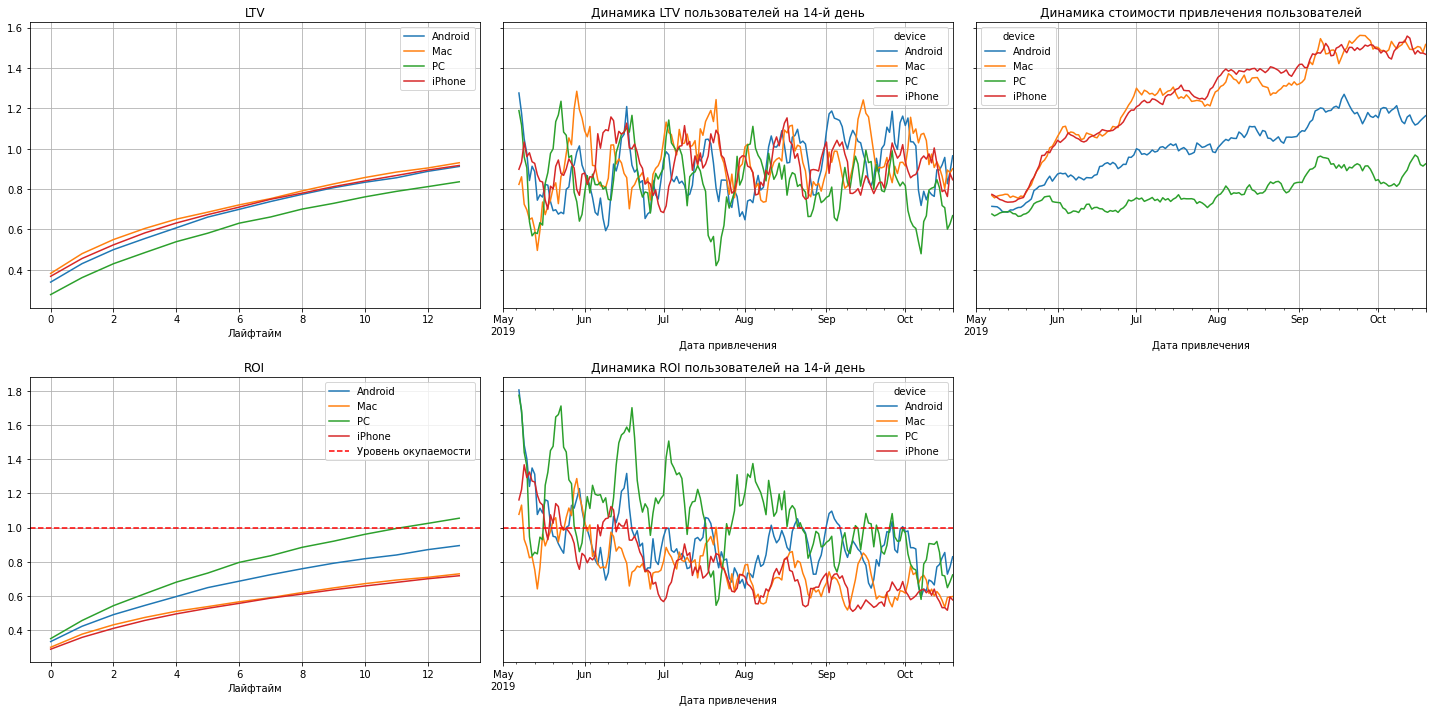

In [20]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_0, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device'], ignore_horizon=False)
display(roi.style.format('{:.2f}'))

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14)

Если смотреть устройства то видно, что окупаемость за 14 дней наблюдается только у пользователей PC. Стоимость привлечения новых пользователей растёт у всех платформ, а особенно у устройств Apple.

#### Анализ окупаемости рекламы по странам

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
region,,,,,,,,,,,,,,,,
France,10516.00,0.46,0.42,0.56,0.68,0.78,0.88,0.98,1.05,1.10,1.18,1.24,1.30,1.35,1.41,1.46
Germany,9030.00,0.46,0.40,0.56,0.71,0.81,0.91,0.99,1.07,1.15,1.23,1.30,1.38,1.43,1.49,1.53
UK,10536.00,0.45,0.48,0.65,0.81,0.92,1.02,1.11,1.22,1.29,1.37,1.42,1.47,1.52,1.58,1.63
United States,58562.00,1.46,0.29,0.36,0.41,0.45,0.48,0.51,0.54,0.57,0.59,0.61,0.63,0.65,0.67,0.69


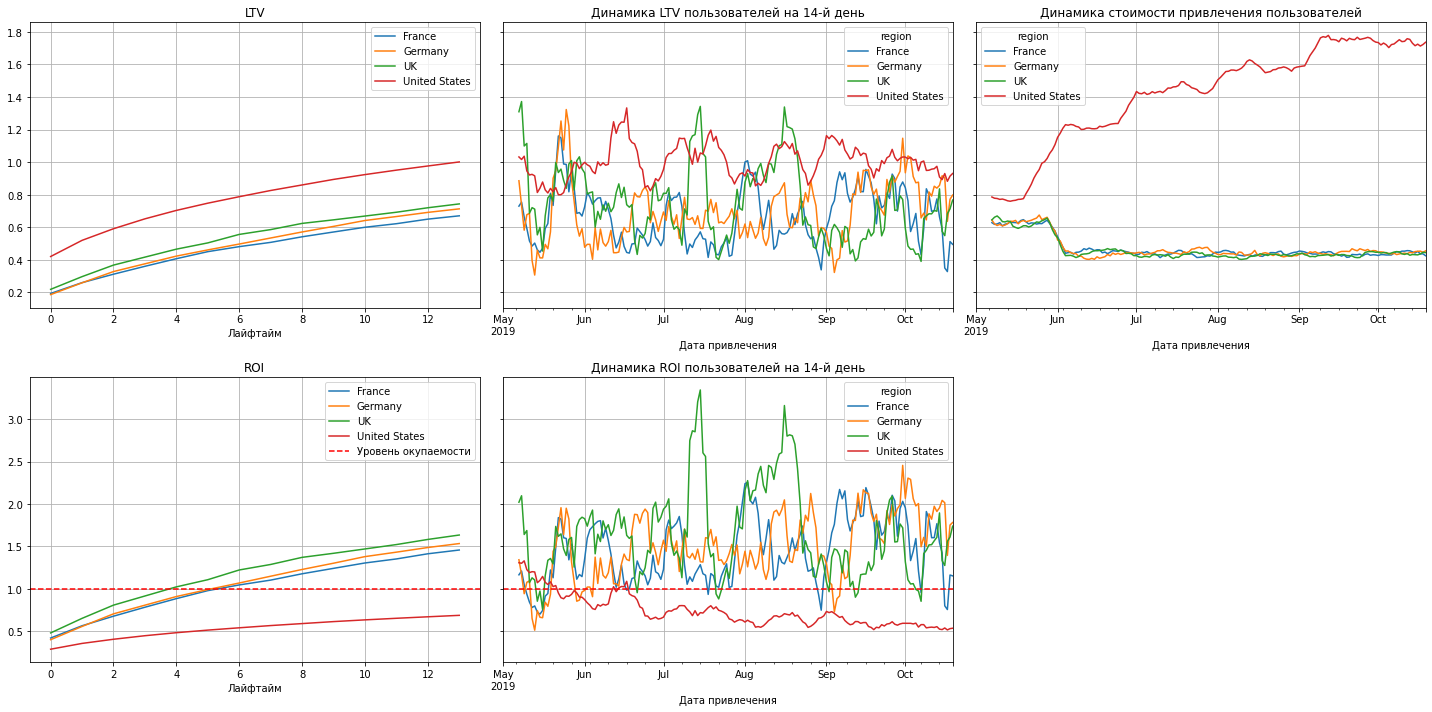

In [21]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_0, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region'], ignore_horizon=False)
display(roi.style.format('{:.2f}'))

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14)

Проанализовав показатели по регионам, мы можем увидеть важные моменты:
Стоимость привлечения новых пользователей растёт сильно только в США и это влияет на средние показатели, так как большинство пользователей из этого региона. Далее можно подробнее изучить именно эту страну, а сначала изучим рекламные каналы.

#### Анализ окупаемости рекламы по рекламным каналам

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,,
AdNonSense,3702.00,1.01,0.50,0.58,0.64,0.68,0.70,0.73,0.75,0.76,0.78,0.80,0.80,0.81,0.82,0.83
FaceBoom,27544.00,1.11,0.53,0.59,0.63,0.65,0.67,0.68,0.70,0.70,0.71,0.72,0.72,0.73,0.73,0.74
LeapBob,8103.00,0.21,0.51,0.74,0.98,1.12,1.24,1.37,1.50,1.59,1.76,1.88,1.99,2.09,2.18,2.25
MediaTornado,4167.00,0.22,0.63,0.87,1.13,1.34,1.52,1.68,1.77,1.91,2.01,2.11,2.22,2.32,2.40,2.44
OppleCreativeMedia,8139.00,0.25,0.39,0.53,0.69,0.83,0.96,1.07,1.16,1.24,1.31,1.39,1.46,1.51,1.58,1.64
RocketSuperAds,4251.00,0.42,0.50,0.76,0.95,1.09,1.24,1.37,1.53,1.65,1.77,1.89,1.99,2.07,2.15,2.24
TipTop,18498.00,2.76,0.12,0.18,0.23,0.27,0.31,0.34,0.37,0.40,0.42,0.45,0.48,0.50,0.52,0.54
WahooNetBanner,8082.00,0.60,0.32,0.48,0.63,0.74,0.86,0.95,1.05,1.13,1.21,1.27,1.35,1.41,1.48,1.53
YRabbit,4102.00,0.22,0.75,0.98,1.18,1.40,1.64,1.79,1.91,2.02,2.12,2.21,2.31,2.41,2.52,2.58


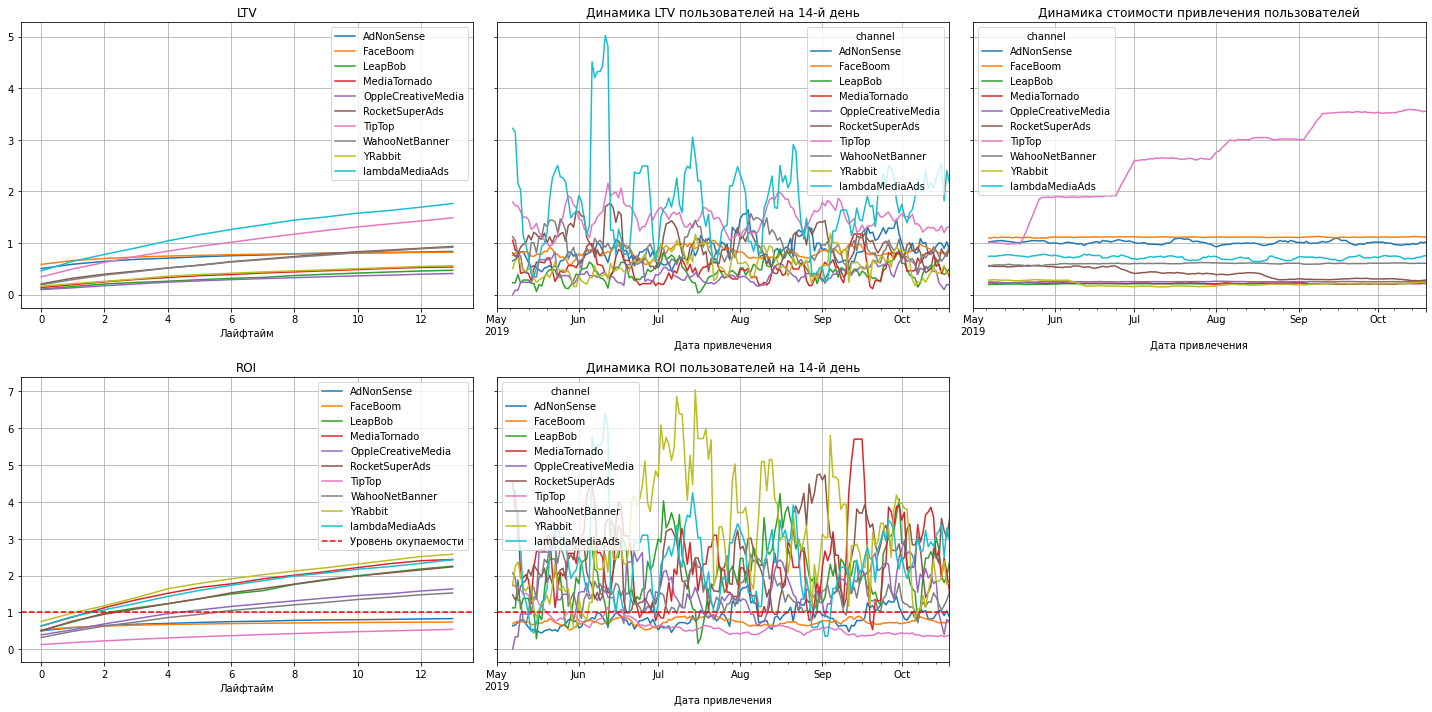

In [22]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_0, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'], ignore_horizon=False)
display(roi.style.format('{:.2f}'))

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14)

Изучив данные по каналам привлечения, можно сдедать вывод, пользователи, привлечённые через самые популярные каналы TipTop, FaceBoom, AdNonSense не окупаются, так как стоимость их привлечения слишком высока. Особенно выросла в течение года стоимость рекламы на TipTop.

#### Изучение конверсии и удержания

Изучим конверсию и удержание пользователей:


##### Конверсия по разным устройствам

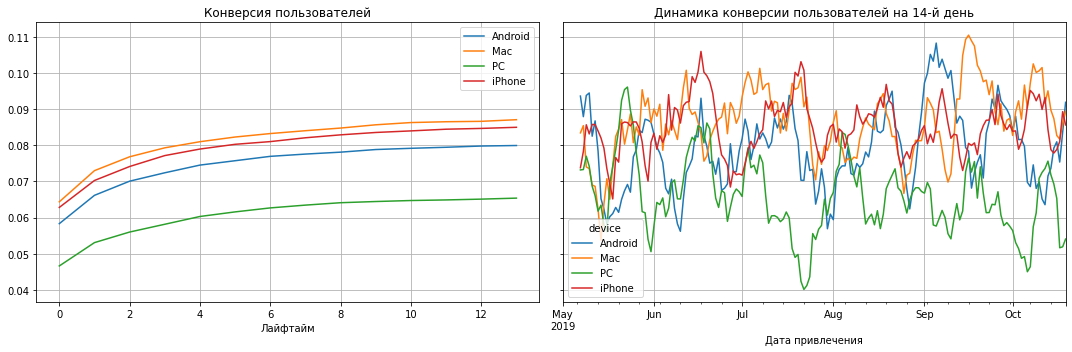

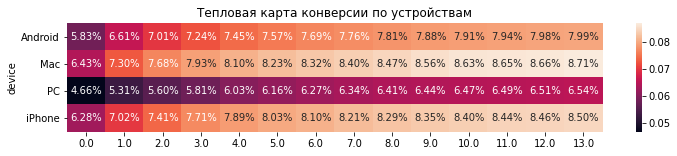

In [23]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_0, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device'])

plot_conversion(conversion, conversion_history, 14) 

plt.figure(figsize=(12, 2))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по устройствам')
plt.show() 

##### Конверсия по разным регионам

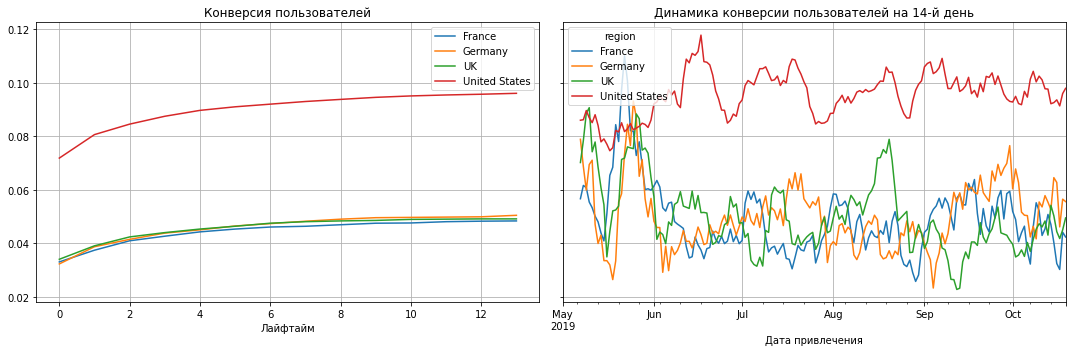

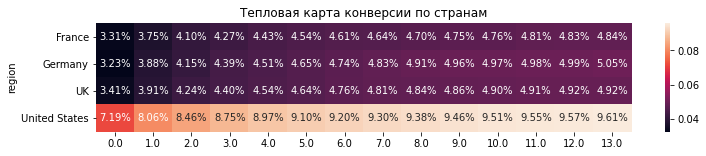

In [24]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_0, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region'])

plot_conversion(conversion, conversion_history, 14) 

plt.figure(figsize=(12, 2))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по странам')
plt.show() 

##### Конверсия по каналам привлечения

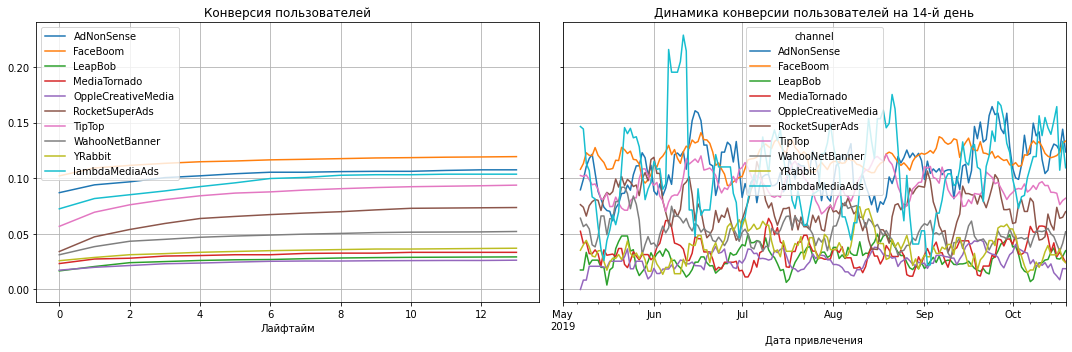

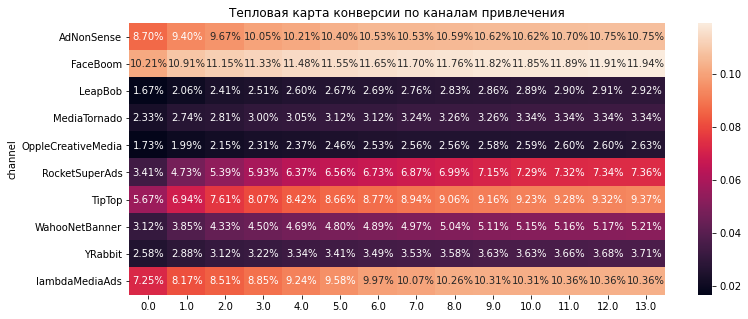

In [25]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_0, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'])

plot_conversion(conversion, conversion_history, 14) 

plt.figure(figsize=(12, 5))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по каналам привлечения')
plt.show() 

##### Удержание по разным устройствам

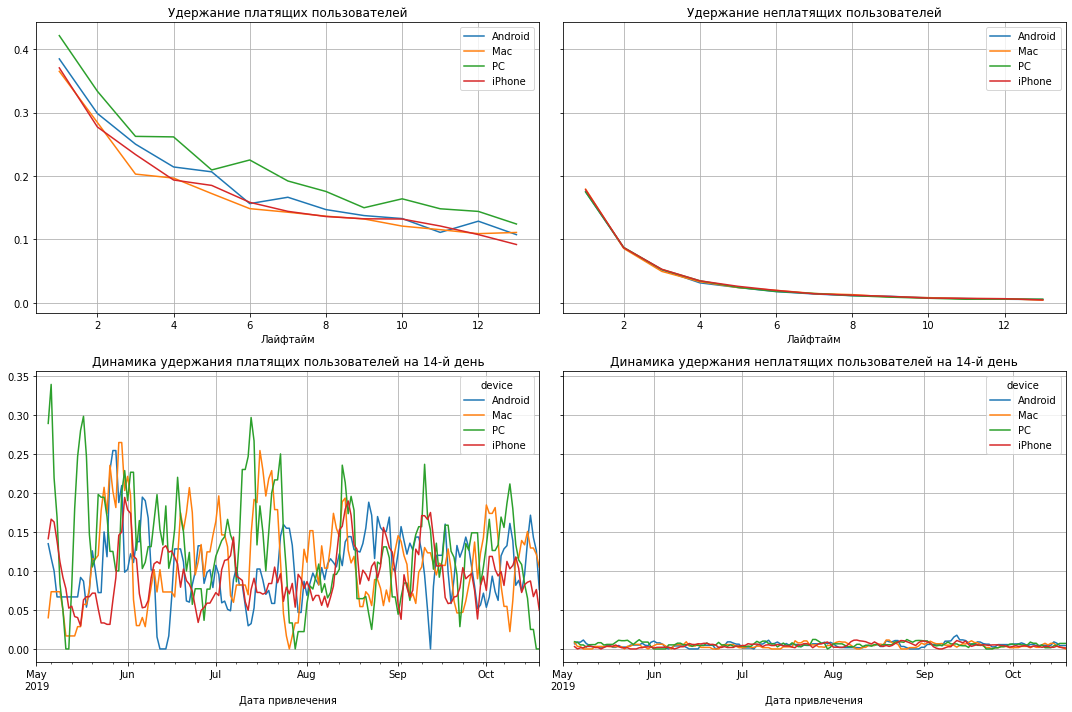

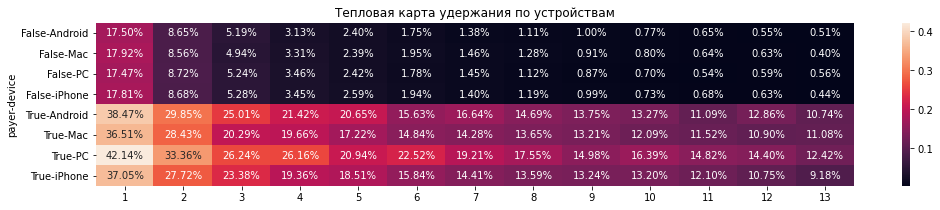

In [26]:
retention_raw, retention, retention_history = get_retention(
    profiles_0, visits, datetime(2019, 11, 1).date(),
    14, dimensions=['device'], ignore_horizon=False)

plot_retention(retention, retention_history, 14) 

plt.figure(figsize=(17, 3))
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания по устройствам')
plt.show()

##### Удержание по регионам

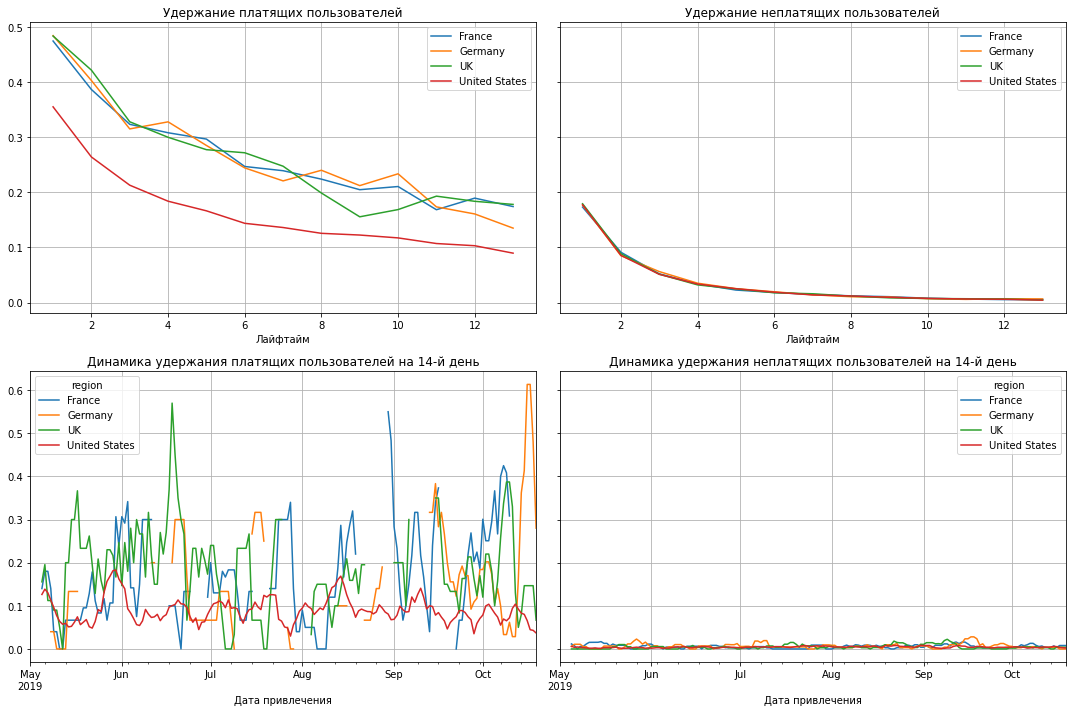

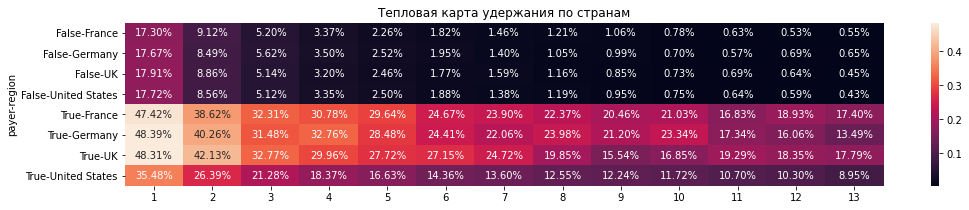

In [27]:
retention_raw, retention, retention_history = get_retention(
    profiles_0, visits, datetime(2019, 11, 1).date(),
    14, dimensions=['region'], ignore_horizon=False)

plot_retention(retention, retention_history, 14)

plt.figure(figsize=(17, 3))
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания по странам')
plt.show()

Изучив данные показатели, можно отметить более высокую в целом конверсию в США, хотя удержание пользователей там в ниже, чем в других регионах. Самые популярные каналы привлечения имеют также хорошую конверсию.

##### Удержание по каналам привлечения

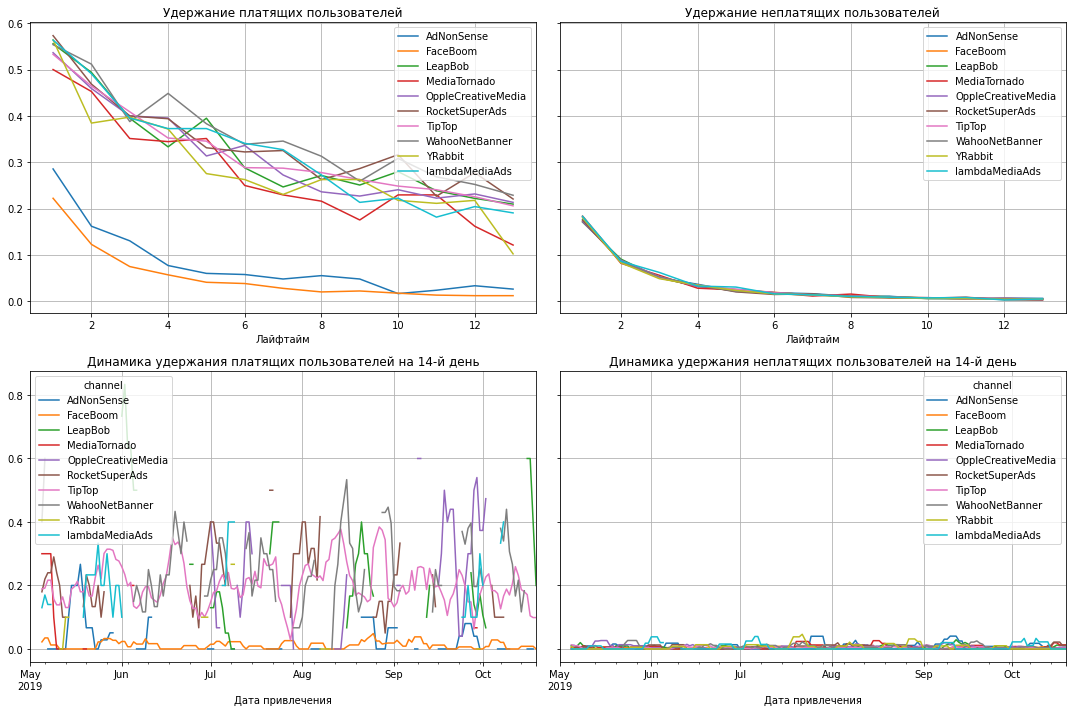

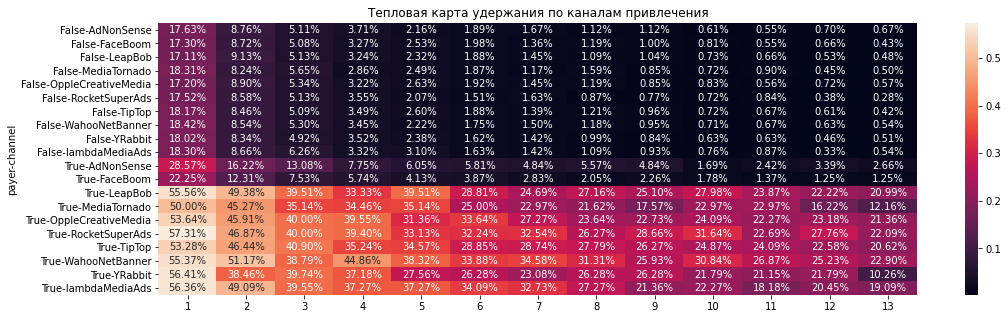

In [28]:
retention_raw, retention, retention_history = get_retention(
    profiles_0, visits, datetime(2019, 11, 1).date(),
    14, dimensions=['channel'], ignore_horizon=False)

plot_retention(retention, retention_history, 14) 

plt.figure(figsize=(17, 5))
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания по каналам привлечения')
plt.show()

#### Изучение региона США

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
device,,,,,,,,,,,,,,,,
Android,11769,1.446872,0.317828,0.391448,0.442858,0.483474,0.523980,0.566074,0.592508,0.620178,0.648492,0.676102,0.695736,0.713025,0.733599,0.751769
Mac,14635,1.448830,0.293188,0.364791,0.413887,0.452821,0.483985,0.508931,0.534349,0.557272,0.582083,0.605948,0.627742,0.645534,0.658714,0.676882
PC,6066,1.455951,0.270443,0.340290,0.391596,0.442124,0.480437,0.508800,0.542248,0.565527,0.587788,0.608244,0.634234,0.657627,0.672882,0.692886
iPhone,26092,1.463872,0.277404,0.341010,0.388360,0.430173,0.465271,0.494196,0.521480,0.549600,0.570219,0.592092,0.610671,0.629563,0.648695,0.664112


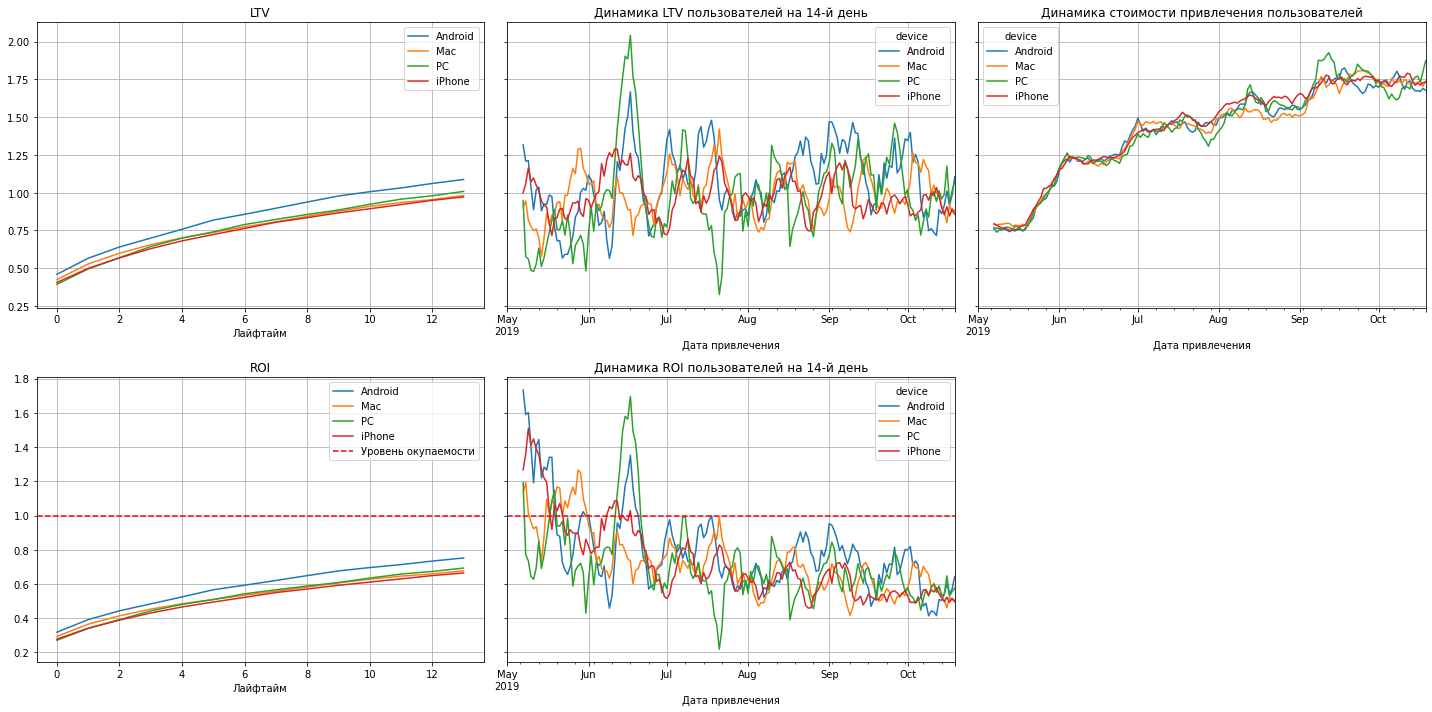

In [29]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_0.query('region == "United States"'), orders, datetime(2019, 11, 1).date(), 14, dimensions=['device'], ignore_horizon=False)
display(roi)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14)

Стоимость привлечения пользователей сильно растёт в течение года на всех устройствах, включая PC. Если в мае была кое-какая двухнедельная окупаемость на некоторых платформах, то дальше её нет и близко. Показатели сильно ухудшаются к ноябрю. Посмотрим какие каналы на это влияют.

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,,
FaceBoom,27544,1.113419,0.526040,0.593510,0.629343,0.654599,0.671035,0.682914,0.695801,0.704818,0.711685,0.719204,0.724119,0.729488,0.734210,0.737790
MediaTornado,4167,0.219035,0.627684,0.874814,1.127410,1.340729,1.516873,1.675432,1.773841,1.910531,2.008962,2.107371,2.216726,2.320602,2.402610,2.436519
RocketSuperAds,4251,0.417431,0.497256,0.763336,0.948932,1.092347,1.235204,1.367935,1.531090,1.646391,1.767923,1.892809,1.991795,2.070538,2.152657,2.237019
TipTop,18498,2.757774,0.124575,0.180359,0.226321,0.268272,0.305449,0.339298,0.367570,0.397585,0.424763,0.451627,0.475535,0.497310,0.517679,0.539532
YRabbit,4102,0.217087,0.752238,0.983122,1.179250,1.400049,1.641119,1.786814,1.910094,2.022179,2.123045,2.212703,2.313569,2.414457,2.516446,2.578086


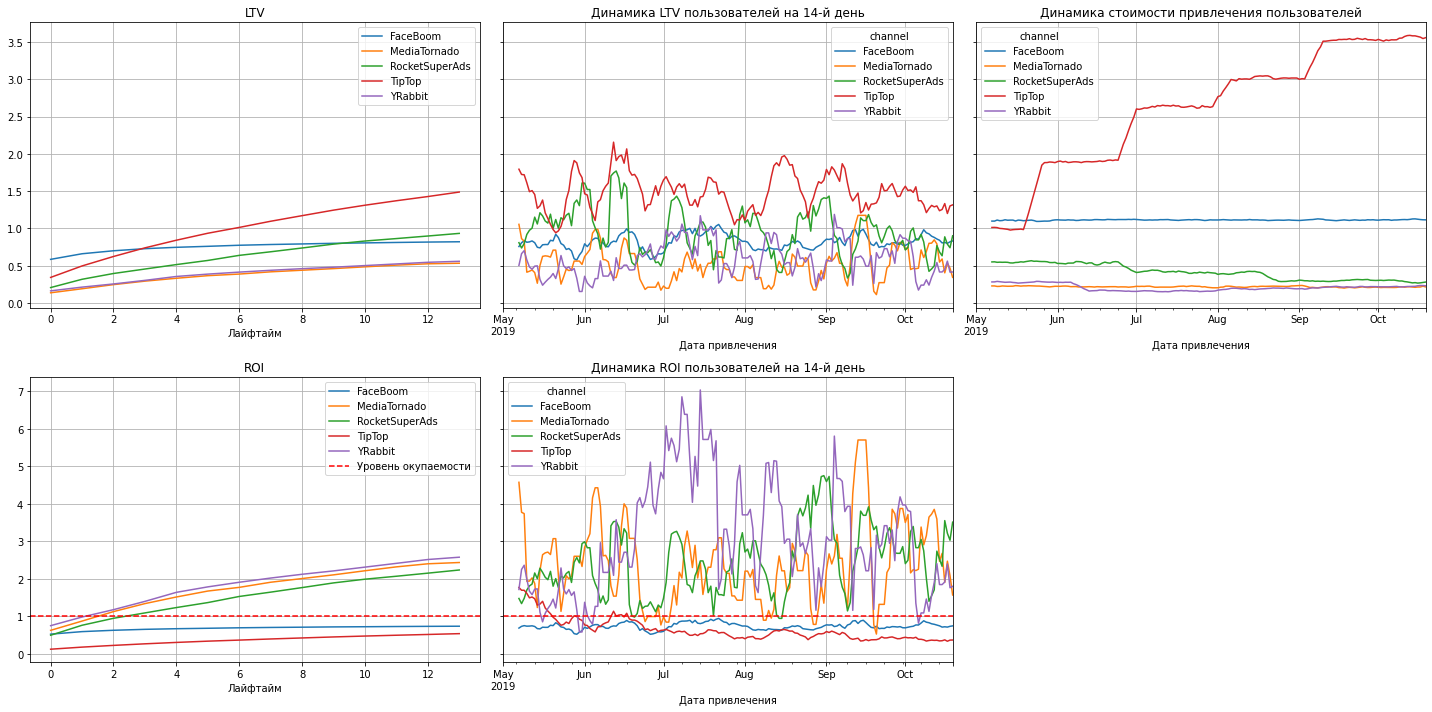

In [30]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_0.query('region == "United States"'), orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'], ignore_horizon=False)
display(roi)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14)

Посмотрев на данные, можно сделать вывод, что два канала с низкой окупаемостью - FaceBoom и TipTop влияют на общий показатель окупаемости - так как они же одновременно самые популярные. Цена рекламы на TipTop крайне высока и продолжает расти.

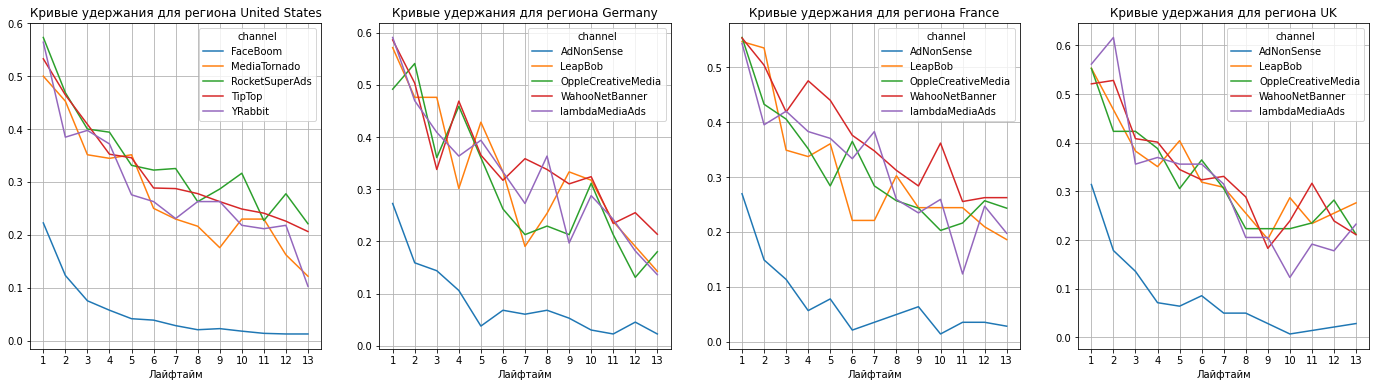

In [31]:
plt.figure(figsize=(24, 6))
for i, region in enumerate(profiles_0['region'].unique()):
    retention_raw, retention, retention_history = get_retention(profiles_0.query('region == @region'), visits, datetime(2019, 11, 1).date(), 14, dimensions=['channel'], ignore_horizon=False)
    retention.query('payer == True').drop(columns=['cohort_size', 0]).droplevel('payer').T.plot(
        grid=True,  # добавляем сетку
        # отметки на оси X — названия колонок
        xticks=list(retention.drop(columns=['cohort_size', 0]).columns.values),
        ax=plt.subplot(1, 4, i + 1), # задаём расположение графиков
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для региона {}'.format(region))


Проанализировав данные, можно сделать вывод, что, несмотря на высокую конверсию от пользователей, привлечённых по каналам FaceBoom, AdNonSence и TipTop, окупаемость рекламы по ним недостаточна по причине высокой стоимости привлечения, а также низкому удержанию пользователей. Больше всего на плохие показатели влияет TipTop и FaceBoom - самые популярные в США.

### Общие выводы

В ходе данной работы были проанализированы логи сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Был проведён анализ расходов на привлечение пользователей, окупаемость рекламы, конверсию и удержание в зависимости от устройств, каналов привлечения и региона.

Сравнив разные показатели и графики я пришёл к выводу, что убытки в первую очередь связаны с очень низкой окупаемостью привлечённых пользователей из США, а именно по каналам FaceBoom и TipTop. Несмотря на хорошую конверсию, привлечение через эти каналы обходится слишком дорого, удержание несколько ниже чем у других каналов.

Рекомендации маркетинговому отделу для повышения эффективности: не привлекать новых пользователей через TipTop и FaceBoom в США, рекламный бюджет переключить на другие каналы привлечения с хорошей окупаемостью.